<a href="https://colab.research.google.com/github/saturnMars/FM_2025/blob/main/Lab3_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In Class Project






## Problem formulation

The aim of this final lab is to give you the possibility to work on a sample project. This will give you a better grasp of how the final project will be conducted and allow you more coding practice compared to previous labs.

The sample project is inspired by the paper [Mind the Gap: Understanding the Modality Gap in Multi-modal Contrastive Representation Learning](https://arxiv.org/pdf/2203.02053.pdf). During the course, we discussed how Vision-Language Models (VLMs) can align representations from language and vision. This alignment can be achieved using contrastive learning on image/captions pairs. However, the paper shows that performing a dimensionality reduction technique on embedded image/caption pairs results in the two modalities being disjointed in the embedding space. You can better visualize this through the following image:

<img src="https://modalitygap.readthedocs.io/en/latest/_images/Figure1.png" width="600">

As shown in the image, the "gap" between the two modalities is present for a randomly initialized network and persists even after the pretraining phase. Moreover, this modality gap is not only present in images/text pairs but also when text is aligned with other modalities (videos, medical images, amino-acid sequences).

Geometrically, the authors talk about a "cone effect," which means that with a growing number of dimensions, embeddings tend to occupy smaller regions of the space assuming a cone-like shape.

Your task will consist of testing whether the "modality gap" and "cone effect" exist using video/caption pairs and a state-of-the-art VLM model, [COCA](https://arxiv.org/pdf/2205.01917.pdf).

## Overview of the project

The project is divided into three main phases, explained in detail in the following sections. These phases are sequential, and you can perform all of them here on Colab using the available T4 GPU.

### Step 1: Video Captioning

Your first task is to perform Video Captioning, which is the automatic captioning of a video by understanding the actions and events in it.

We will provide you with short videos and no captions. Then, you'll have to extract a number of frames from each video and generate an independent caption for each frame using COCA.

You are free to choose how many frames to extract from each video, how many of these frames will be used to generate captions, how many captions to retain for each video, and which strategy to use to generate captions.

As you can imagine, many frames of a single video might be repetitive and lead to the same caption, and conversely, few key frames might contain different actions that are necessary to understand the dynamic of the event represented in the video (For example, think about a tennis player serving; probably the initial frames of the video will depict the player in a static position, focusing and preparing to serve, whereas the act of serving will be present only in fewer frames). There are multiple solutions to this problem, and you are free to choose one. Some examples are:

* Subsample only a smaller number of frames and generate captions only for those (faster).
* Filter captions based on their diversity. An approach is to cluster similar captions using the text encoder of COCA and take only one caption for each cluster (slower).

### Step 2: Caption Aggregation

At the end of step 1, you'll have a collection of captions for each single video, with these captions describing only some frames but not the video overall.

Your second task is to obtain a single summary describing the content of a video by aggregating the content of your captions. To this end, you have to choose a LLM and prompt it to generate an overall description of a video given a list of captions.

As an LLM you can use a model from the [FLAN-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5) family. These models have good instruction-following capabilities and work well out-of-the-box. If you have any other preference, you are free to choose other LLMs.

P.S. After doing some experiments I found the [Phi-1.5](https://huggingface.co/microsoft/phi-1_5) model to be a good compromise in terms of memory requirements and performance. This model had no training to follow instructions, so to make it do what you want you will have to provide in-context examples and see how it performs in a few shots manner. See image below:

<img src="https://ai.stanford.edu/blog/assets/img/posts/2022-08-01-understanding-incontext/images/image11.gif" width="600">


### Step 3: Evaluation with NLG metrics
1. *Lexical-based comparsion*: ROUGE
2. *Semantic-based comparison*: Cosine similarity

### Step 4: Multi-modal alignment

Once you have paired videos and captions, you are ready to see if the "modality gap" is present for these data points.

Your task is now to encode both videos and captions and use U-MAP dimensionality reduction to project the embeddings in a 2-D space. Since videos are composed of multiple frames, you'll have to use a fusion strategy to aggregate the embedding of all frames. For example, you can take the average of the embeddings to represent a whole video.

If the results are as expected, at this point, you should see two different clusters of data points, each representing one modality.

### Step 5: Comparison with a native Vision-Language Model (VLM)

## Getting started

All the tools necessary to perform these tasks were provided during the course of previous labs.

You can also find here a list of tools.

* **FFMPEG TO EXTRACT FRAMES FROM VIDEOS**

  This is the command for extracting frames from a video specifying the frame rate using FFmpeg:

  ```
  ffmpeg -i input.mp4 -vf fps=1 %04d.png
  ```

  `%04d.png` is a sequence pattern type used to interpret the output file names by sequencing them with zero-padded sequential numbers, eg. 0001.png, 0002.png, 0003.png, etc.

* **OPEN CLIP TO ACCESS THE COCA MODEL**

  This is the [link](https://github.com/mlfoundations/open_clip) to the Open CLIP repository.

* **U-MAP FOR DIMENSIONALITY REDUCTION**

  This is the official [documentation](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) of the python implementation of U-MAP.




In [1]:
import torch
if not torch.cuda.is_available():
    print("⚠️ GPU not enabled. Go to Runtime → Change runtime type → select 'T4 GPU'")
else:
    print(f"✅ GPU active: {torch.cuda.get_device_name(0)}")

✅ GPU active: Tesla T4


# Step 1.0: Get the data

In [2]:
from datasets import load_dataset
from huggingface_hub import snapshot_download

### Get the video-caption pairs

In [3]:
# Load dataset (videos with captions)
dataset = load_dataset("friedrichor/ActivityNet_Captions")

# Keep only a sample of 1000 examples for testing
df = dataset['train']#.take(10)

# Visualize first sample
print(f"Samples: {len(df)} || ITEM 0:", df[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Samples: 10009 || ITEM 0: {'video_id': 'v_QOlSCBRmfWY', 'video': 'v_QOlSCBRmfWY.mp4', 'caption': 'A young woman is seen standing in a room and leads into her dancing. The girl dances around the room while the camera captures her movements. She continues dancing around the room and ends by laying on the floor.', 'source': 'ActivityNet_Captions', 'duration': 82.73, 'timestamps': [[0.8300000000000001, 19.86], [17.37, 60.81], [56.26, 79.42]], 'sentences': ['A young woman is seen standing in a room and leads into her dancing.', 'The girl dances around the room while the camera captures her movements.', 'She continues dancing around the room and ends by laying on the floor.']}


### Get raw videos

In [4]:
from os import path, rename, listdir, remove, makedirs

In [5]:
max_num_videos = 10

video_folder = path.join('data', 'videos')
if not path.exists(video_folder):

    # Download the files from Hugging Face --> Take only one part to reduce download size
    snapshot_download(repo_id="friedrichor/ActivityNet_Captions", repo_type="dataset", allow_patterns=["*.tar.part-000"], local_dir='./data/raw')

    # Combine the parts into a single tar file and extract it
    !cat ./data/raw/ActivityNet_Videos.tar.part-* | tar -vxf - -C ./data

    # Rename the extracted folder to a simpler name
    rename(path.join('data', 'Activity_Videos'), video_folder)

    # Delete the parts to save space
    !rm -r -f ./data/raw

    # Keep only a subset of videos for testing
    counter = 0
    for idk, video_file in enumerate(listdir(video_folder)):
        if counter >= max_num_videos:
            remove(path.join(video_folder, video_file))
        counter += 1

# Print the number of videos downloaded
print('Raw videos:', len(listdir(video_folder)))

Raw videos: 10


# Step 1.1: Extract frames from videos

In [5]:
!apt install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [6]:
from glob import glob
from os import makedirs
import subprocess

In [7]:
# define a directory to store video frames and create it
video_frames_dir = path.join("data", "frames")
if not path.exists(video_frames_dir):
    makedirs(video_frames_dir)

# iterate through videos
for i, video in enumerate(glob("data/videos/*")):
    video_name = path.basename(video).split(".")[0]

    # create new directory to store frames from a video
    frames_dir = path.join(video_frames_dir, video_name)
    makedirs(frames_dir, exist_ok=True)

    # define ffmpeg command
    ffmpeg_command = [
        'ffmpeg', # ffmpeg/bin/ffmpeg
        '-i', video,
        '-vf', 'fps=1',
        f'{frames_dir}/%02d.png'
    ]

    # run command
    subprocess.call(ffmpeg_command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Step 1.2: Caption video frames

In [8]:
!pip install -U open-clip-torch transformers==4.56.2

In [9]:
from collections import defaultdict
from tqdm import tqdm
from PIL import Image
import open_clip

### OpenCLIP, an open source implementation of OpenAI's CLIP (Contrastive Language-Image Pre-training)

In [26]:
device = torch.device('cuda')

# Instantiate CLIP-inspired model --> Contrastive Captioners (CoCa), Image-Text Foundation Models
model, _, preprocess = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k",
  device=device,
  precision = torch.bfloat16)

In [27]:
# set model to evaluation mode
model.eval()

# iterate through video directories
captions_dict = defaultdict(list)
for video_dir in tqdm(glob(f"{video_frames_dir}/*")):

    # get video name
    video_id = path.basename(video_dir)

    # iterate through frames in the video directory
    frame_files = sorted(glob(f"{video_dir}/*"))
    for frame_path in frame_files:

        # preprocess frame
        im = Image.open(frame_path).convert("RGB")
        im = preprocess(im).unsqueeze(0).to(device)

        # generate caption for frame
        with torch.no_grad():
            generated = model.generate(im)

        # add generated caption to dictionary
        caption = open_clip.decode(generated[0]).replace("<start_of_text>", "").replace("<end_of_text>", "").strip()
        captions_dict[video_id].append(caption)

100%|██████████| 1/1 [02:08<00:00, 128.67s/it]


In [28]:
# Clean up memory
del model, preprocess, im, generated

import gc
gc.collect()

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

### Display captions for first video

In [15]:
import matplotlib.pyplot as plt

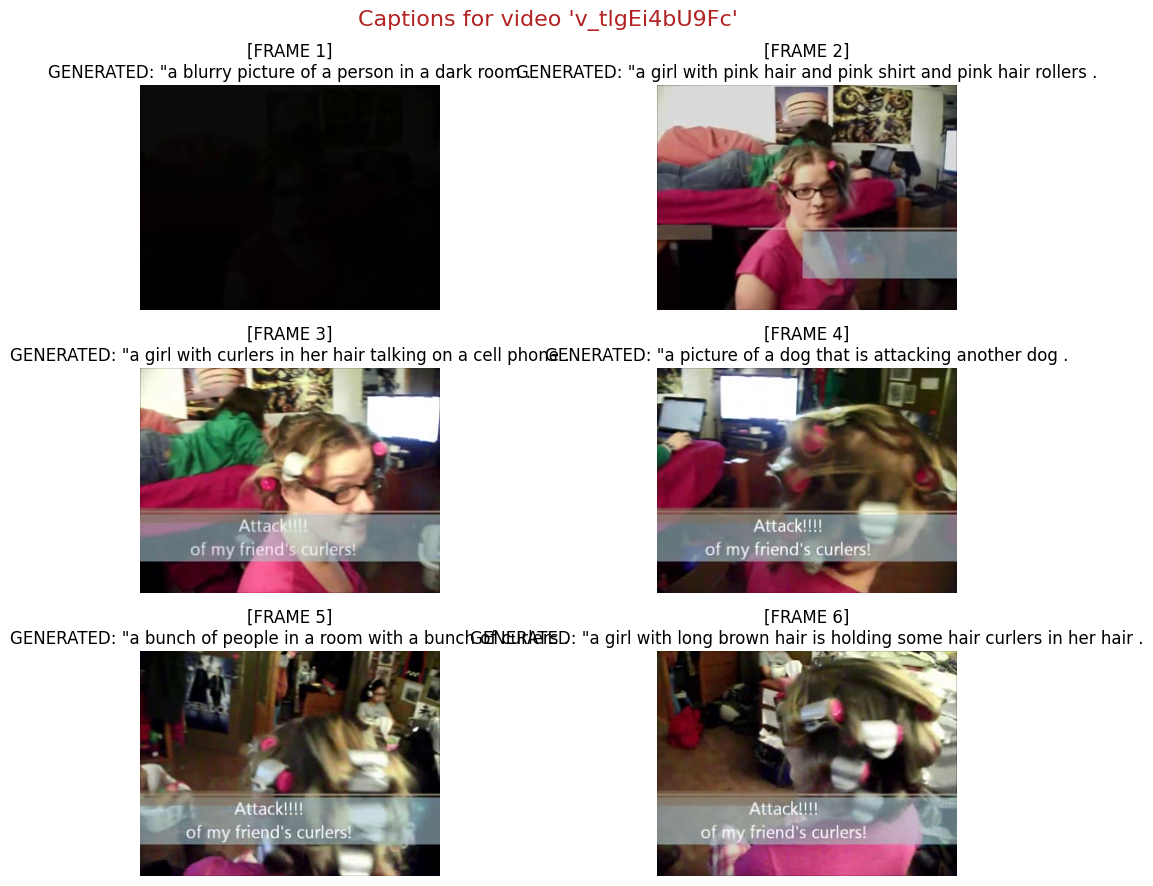

In [16]:
# Display captions for first video
first_video_id = list(captions_dict.keys())[0]

# Select a number of frames to visualize
num_frames_to_viz = 6
generated_captions = captions_dict[first_video_id][:num_frames_to_viz]

# Create the main figure
ncols = 2
nrows = (num_frames_to_viz + 1) // ncols

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6 * ncols, 3 * nrows))

fig.suptitle(f"Captions for video '{first_video_id}'", fontsize=16, color = 'firebrick')

# Iterate through frames and captions and create subplots
for idk, ax in enumerate(axes.flatten()):

    # Get the caption
    caption = generated_captions[idk]

    # Load the image from the disk
    img = Image.open(path.join(video_frames_dir, first_video_id, f"{idk+1:02d}.png"))

    # Visualize the image on the notebook
    ax.imshow(img)
    ax.set_title(f'[FRAME {idk + 1}]\nGENERATED: "{caption}')
    ax.axis('off')

# Visualize the figure
fig.tight_layout()
plt.show()

# Step 2: Use a LLM to generate a single caption for a video
TASK: Aggregate and summarize the frame captions

In [29]:
from transformers import AutoModelForCausalLM, AutoTokenizer

In [30]:
model_name = 'microsoft/Phi-4-mini-instruct'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", dtype = torch.bfloat16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [31]:
# Set model to evaluation mode
model.eval()

# Iterate through videos
aggregated_captions = dict()
for video_id in tqdm(captions_dict):

    # Aggregate all the frame captions to generate a context
    video_sentences = '\n'.join(captions_dict[video_id])

    # Define the instruction prompt with (1) task description, (2) in-context examples, and (3) input sentence.
    prompt = f"""
    Instruction:
    Create a summary sentence that aggregate the meaning of all the sentences provided in the context. The sentences in the context are in cronological order. Provide a concise summary using only the information provided in the context.

    Context:
    The two kids are playing with the cat
    The cat is runnning in the living room .
    The cat is runnning in the living room .
    Two kids are trying to catch a black cat
    One child is running in the living room .
    The cat is runnning in the living room .
    A woman is holding a black cat .
    The children and a woman are petting the cat .

    Summary:
    Two children run into the living room trying to catch a black cat. After a woman catches the cat, they all pet it together .

    Context:
    {video_sentences}

    Summary:
    """

    # Generate aggregate captions using the LLM
    with torch.no_grad():
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        outputs = model.generate(**inputs, repetition_penalty=1.2, max_new_tokens=50)
    generated_text = tokenizer.decode(outputs[0][len(inputs.input_ids.squeeze()):], skip_special_tokens=True).strip()

    # Attach the summarized caption to the video
    aggregated_captions[video_id] = generated_text

100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


In [32]:
# Clean up memory
del model, inputs, outputs

import gc
gc.collect()

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

#### Visualize the aggregated caption

In [ ]:
video_id = list(aggregated_captions.keys())[0]

print("AGGREGATED:", aggregated_captions[video_id])
print(f"ORIGINAL CAPTIONS ({len(glob(path.join('data', 'frames',video_id, '*.png')))} frames || {len(captions_dict[video_id])} captions):")
for frame_id, caption in enumerate(captions_dict[video_id]):
    print(f'- FRAME {frame_id + 1}: "{caption}"')

# Step 3: Evaluation with NLG metrics

In [36]:
!pip install evaluate rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=ae721745033847829c2683e2011368a18b4ade4359d983c64a36e7a1a7f18126
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [37]:
import evaluate
import seaborn as sns
rouge_metric = evaluate.load("rouge")

In [38]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [39]:
# Set verbose to True to visualize per-video results
verbose = True

# Compute metrics for each video
coca_stats = defaultdict(list)
for video_id, generated_caption in aggregated_captions.items():

    # Get the target caption from the dataset
    target_caption = df.filter(lambda x: x['video_id'] == video_id)[0]['caption']

    # Compute ROUGE scores
    rouge_results = rouge_metric.compute(predictions = [generated_caption], references = [target_caption])

    # Compute embeddings
    target_embedding = embedding_model.encode([target_caption])
    generated_embedding = embedding_model.encode([generated_caption])
    similarity = embedding_model.similarity(target_embedding, generated_embedding).item()

    # Store stats
    coca_stats['rouge1'].append(rouge_results['rouge1'])
    coca_stats['rouge2'].append(rouge_results['rouge2'])
    coca_stats['cosine_sim'].append(similarity)

    # Visualize results
    if verbose:
        print('-' * 15, f'VIDEO ID ({video_id})', '-' * 15)
        print(f'TARGET:"{target_caption}"\nGENERATED: "{generated_caption}"')
        print(f"--> ROUGE-1 (unigrams) --> F1 Score: {rouge_results['rouge1']:.2f}")
        print(f"--> ROUGE-2 (bigrams)  --> F1 Score: {rouge_results['rouge2']:.2f}")
        print(f'--> COSINE SIMILARITY: {similarity:.2f}\n')

# Print average results
sns.boxplot(data=coca_stats, palette="Set2", width=0.5)
plt.title("Distribution of Evaluation Metrics for Video Captioning")
plt.ylim(0, 1)
plt.show()

Filter:   0%|          | 0/10009 [00:00<?, ? examples/s]

IndexError: Invalid key: 0 is out of bounds for size 0

In [40]:
# Clean up memory
del embedding_model, target_embedding, generated_embedding

import gc
gc.collect()

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

NameError: name 'target_embedding' is not defined

# Step 4: Visualise multi-modal alignment by projecting video/caption embeddings in a low dimensional space

In [ ]:
from open_clip.factory import get_tokenizer
from umap import UMAP

In [ ]:
# instantiate again text-caption model
model, _, preprocess = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k",
  device=device
  precision = torch.bfloat16
)

### Step 3.1: Get the video embeddings

In [ ]:
# Set model to evaluation mode
model.eval()

# Iterate through video files
video_embeddings = list()
for video_path in tqdm(glob(f"{video_frames_dir}/*")):

    # get video name
    video_id = path.basename(video_dir)

    # iterate through frames in the video directory
    frame_embeddings = list()
    for frame_path in sorted(glob(f"{video_dir}/*")):

        # preprocess frame
        im = Image.open(frame_path).convert("RGB")
        im = preprocess(im).unsqueeze(0).to(device)

        # generate caption for frame
        with torch.no_grad():
            image_features = model.encode_image(im).float()

        # Normalize features
        image_features /= image_features.norm(dim=-1) # keepdim=True

        # Store the frame features
        frame_embeddings.append(image_features.cpu().squeeze())

    # Save the video embedding as the average of the frame embeddings
    video_embeddings.append(torch.stack(frame_embeddings).mean(dim=0))

# Transform list to tensor
video_embeddings = torch.stack(video_embeddings)
print("\nVideo embeddings:", video_embeddings.shape)

### Step 3.2: Get the caption embeddings

In [ ]:
# Get the textual tokenizer of the model
tokenizer = get_tokenizer("coca_ViT-L-14")

# Iterate through aggregated captions to get caption embeddings
caption_embeddings = list()
for video_id, caption in aggregated_captions.items():

    # Tokenize the caption
    input_ids = tokenizer(caption).to(device)

    # Process the tokenized caption
    with torch.no_grad():
        text_features = model.encode_text(input_ids).float()

    # Normalize features
    text_features /= text_features.norm(dim=-1)

    # Store the caption embedding
    caption_embeddings.append(text_features.cpu().squeeze())

# Transform list to tensor
caption_embeddings = torch.stack(caption_embeddings)
print("Caption embeddings:", caption_embeddings.shape)

In [ ]:
# Clean up memory
del model, im, generated

import gc
gc.collect()

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

### UMAP: Uniform Manifold Approximation and Projection

In [ ]:
# Instantiate umap
reducer = UMAP()

# obtain 2d features
reduced_features = reducer.fit_transform(torch.concat([video_embeddings, caption_embeddings], dim=0))
reduced_videoFeatures = reduced_features[:len(video_embeddings)]
reduced_textFeatures = reduced_features[len(video_embeddings):]

# plot 2d features
plt.scatter(x = reduced_videoFeatures[:, 0], y = reduced_videoFeatures[:, 1], c='tab:blue', label="video")
plt.scatter(x = reduced_textFeatures[:, 0], y = reduced_textFeatures[:, 1], c='tab:red', label="text")

# Plot conneting lines
for i in range(len(video_embeddings)):
    point_video = (reduced_videoFeatures[i, 0], reduced_textFeatures[i, 0])
    point_text = (reduced_videoFeatures[i, 1], reduced_textFeatures[i, 1])
    plt.plot(point_video, point_text, c='black', alpha=0.1)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

### SVD: Singular Value Decomposition

In [ ]:
from numpy.linalg import svd
def compute_svd(X, n_components=2):
    U, S, Vt = svd(X)
    return U[:, :n_components] * S[:n_components]

In [ ]:
# obtain 2d features
reduced_features = compute_svd(torch.concat([video_embeddings, caption_embeddings], dim=0))
reduced_videoFeatures = reduced_features[:len(video_embeddings)]
reduced_textFeatures = reduced_features[len(video_embeddings):]

# plot 2d features
plt.scatter(x = reduced_videoFeatures[:, 0], y = reduced_videoFeatures[:, 1], c='tab:blue', label="Video")
plt.scatter(x = reduced_textFeatures[:, 0], y = reduced_textFeatures[:, 1], c='tab:red', label="Text")

# Plot conneting lines
for i in range(len(video_embeddings)):
    point_video = (reduced_videoFeatures[i, 0], reduced_textFeatures[i, 0])
    point_text = (reduced_videoFeatures[i, 1], reduced_textFeatures[i, 1])
    plt.plot(point_video, point_text, c='black', alpha=0.1)

plt.xlabel('SVD 1')
plt.ylabel('SVD 2')
plt.legend()
plt.show()

# Step 5: Comparison with a Vision-Language Model (VLM)

In [1]:
!pip install -U torchcodec

In [ ]:
%reset -f

In [ ]:
import gc
gc.collect()

In [2]:
import torch
from glob import glob
from os import path

In [3]:
model_name = "Qwen/Qwen2.5-VL-3B-Instruct"

In [4]:
from transformers import pipeline
pipe = pipeline("image-text-to-text", model = model_name, dtype = torch.bfloat16, device = torch.device('cuda'))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
Device set to use cuda


In [ ]:
# Define the instruction for the VLM
task_instruction = "Describe the video in detail."

# Iterate through videos
vlm_generated_captions = dict()
for video_path in glob("data/videos/*"):

    #print("Video path:", video_path, path.abspath(video_path))

    # Prepare message
    messages = [{
        "role": "user",
        "content": [
            {"type": "video", "video": video_path, "max_pixels": 36*42, "fps": 1.0},
            {"type": "text", "text": task_instruction}]
        }]

    # Generate response
    response = pipe(messages)

    # Get the generated text
    generated_text = response[0]['generated_text'].strip()

    print("Response:", response[0]['generated_text'])

    # Get video name
    video_name = path.basename(video_path).split(".")[0]

    # Store the generated caption
    vlm_generated_captions[video_name] = generated_text

In [60]:
# Clean up memory
del pipe, response

import gc
gc.collect()

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

NameError: name 'pipe' is not defined

## Evaluate the generated text

In [ ]:
# Set verbose to True to visualize per-video results
verbose = True

# Compute metrics for each video
vlm_stats = defaultdict(list)
for video_id, generated_caption in vlm_generated_captions.items():

    # Get the target caption from the dataset
    target_caption = df.filter(lambda x: x['video_id'] == video_id)[0]['caption']

    # Compute ROUGE scores
    rouge_results = rouge_metric.compute(predictions = [generated_caption], references = [target_caption])

    # Compute embeddings
    target_embedding = embedding_model.encode([target_caption])
    generated_embedding = embedding_model.encode([generated_caption])
    similarity = embedding_model.similarity(target_embedding, generated_embedding).item()

    # Store stats
    vlm_stats['rouge1'].append(rouge_results['rouge1'])
    vlm_stats['rouge2'].append(rouge_results['rouge2'])
    vlm_stats['cosine_sim'].append(similarity)

    # Visualize results
    if verbose:
        print('-' * 15, f'VIDEO ID ({video_id})', '-' * 15)
        print(f'TARGET:"{target_caption}"\nGENERATED: "{generated_caption}"')
        print(f"--> ROUGE-1 (unigrams) --> F1 Score: {rouge_results['rouge1']:.2f}")
        print(f"--> ROUGE-2 (bigrams)  --> F1 Score: {rouge_results['rouge2']:.2f}")
        print(f'--> COSINE SIMILARITY: {similarity:.2f}\n')

# Print average results
sns.boxplot(data=vlm_stats, palette="Set2", width=0.5)
plt.title("Distribution of Evaluation Metrics for Video Captioning")
plt.ylim(0, 1)
plt.show()